In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Explore Database

In [10]:
inspector = inspect(engine)

In [11]:
#review columns
columns= inspector.get_columns('measurement')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
#2017 didn't have a full year of data
# Perform a query to retrieve the data and precipitation scores
twenty16_prcp_rates = engine.execute("SELECT date, prcp FROM measurement WHERE date BETWEEN '2016-01-01' AND '2016-12-31';").fetchall()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(twenty16_prcp_rates, columns=['date','Precipitation'])
df.set_index('date', inplace=True)

# Sort the dataframe by date
df.sort_values(by='date')
df.tail()

,Precipitation
date,
2016-12-27,0.14
2016-12-28,0.14
2016-12-29,1.03
2016-12-30,2.37
2016-12-31,0.90


In [13]:
df.dtypes

Precipitation    float64
dtype: object

In [14]:
#chart variables 

prcp_values = df['Precipitation']
y_axis = list(prcp_values)

x_axis = df.index

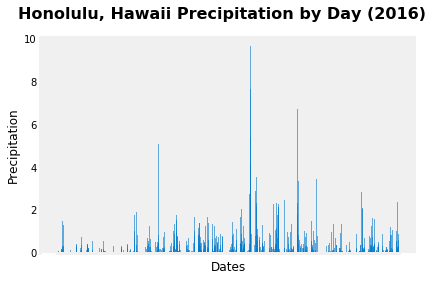

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()

# Orient widths. Add labels, tick marks, etc.
fig.suptitle('Honolulu, Hawaii Precipitation by Day (2016)', fontsize = 16, fontweight = 'bold')
ax.set_ylabel('Precipitation', fontsize = 12)
ax.set_xlabel('Dates', fontsize = 12)
ax.autoscale()

# format border
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['ytick.color']='#333F4B'
#format spine
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

#remmove xticks
ax.set_xticklabels([])

#ax.use_sticky_edges = False
ax = plt.bar(x_axis,y_axis,color='#007acc', alpha=0.6)
plt.grid(False)


plt.savefig('adv_sql_pcrp_by_date.png',dpi=100, bbox_inches = 'tight')

plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df.describe().round(2)

,Precipitation
count,2069.00
mean,0.18
std,0.51
min,0.00
25%,0.00
50%,0.02
75%,0.15
max,9.64


In [17]:
# Design a query to show how many stations are available in this dataset?
num_of_stations = engine.execute("SELECT COUNT(DISTINCT station) FROM measurement;").fetchall()
num_of_stations

[(9,)]

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
data_per_station = engine.execute("SELECT station, COUNT(station) FROM measurement GROUP BY station;").fetchall()
data_per_station

[('USC00511918', 1979),
 ('USC00513117', 2709),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00517948', 1372),
 ('USC00518838', 511),
 ('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00519523', 2669)]

In [19]:
#convert result into a dictionary to extract most active station in result
def Convert(tup, di): 
    di = dict(tup) 
    return di 
      
# Driver Code  
dictionary = {} 
active_stations = (Convert(data_per_station, dictionary)) 

In [20]:
#source:[covert tuple into dict]: https://www.geeksforgeeks.org/python-convert-list-tuples-dictionary/

In [21]:
most_active_station = max(active_stations, key=active_stations.get)
most_active_station

'USC00519281'

In [22]:
#source: [get max from dict]: https://stackoverflow.com/questions/14091636/get-dict-key-by-max-value

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_temp_summary =  engine.execute(f"SELECT station, MAX(tobs), MIN(tobs), ROUND(AVG(tobs),2) FROM measurement WHERE measurement.station = '{most_active_station}' GROUP BY measurement.station;").fetchall()

#!-- not required ; just wanted to show the values in a table format w. headers
df_station = pd.DataFrame(station_temp_summary, columns=['Most active station','Max temp','Min temp','Avg Temp'])
df_station

,Most active station,Max temp,Min temp,Avg Temp
0,USC00519281,85.0,54.0,71.66


In [34]:
# Choose the station with the highest number of temperature observations.
mactive_station__2016_temp_summary =  engine.execute(f"SELECT station, tobs FROM measurement WHERE measurement.station = '{most_active_station}';").fetchall()

# Query the last 12 months of temperature observation data for this station
## I created my own bins so that data is available for other forms of charts, but not required for histogram
df_temp = pd.DataFrame(mactive_station__2016_temp_summary, columns=['Most active station','Temp'])

#!-- Not required
#round values by 10 
def bins(x, base=5):
    return base * round(x/base)

df_temp['Temp Bins'] = bins(df_temp['Temp'])
temp_frequency_values = df_temp['Temp Bins'].value_counts()


In [36]:
#!-- Not required
#created dataframe of temp bins and frequency
df_temp_freq = pd.DataFrame({"Frequency": temp_frequency_values}).reset_index()
df_temp_freq = df_temp_freq.rename(columns={"index":"Temp"})

,Temp,Frequency
0,70.0,1118
1,75.0,1002
2,65.0,336
3,80.0,218
4,60.0,82
5,55.0,11
6,85.0,5


In [44]:
#established temp column for historgam 
df_temp_historgram = df_temp.drop(columns=['Most active station','Temp Bins'])

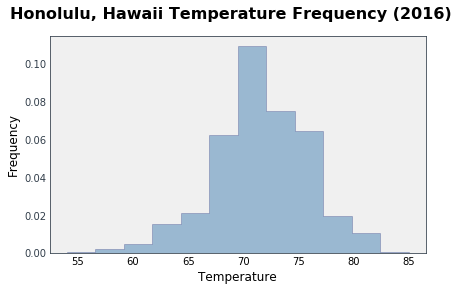

In [111]:
#plot histogram of temp & frequency
plt.hist(df_temp_historgram['Temp'], bins=12, normed=True, alpha=0.5, histtype='stepfilled', color='steelblue', edgecolor='midnightblue')

#chart attributes
plt.suptitle('Honolulu, Hawaii Temperature Frequency (2016)', fontsize = 16, fontweight = 'bold')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(False)

#save chart as fig
plt.savefig('adv_sql_temp_freq.png',dpi=100, bbox_inches = 'tight')

plt.show()


In [73]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):

    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-01-01', '2016-01-31'))
twenty_sixteen_temp_calcs = calc_temps('2016-01-01', '2016-01-31')
jan_2016_temp_calcs= round(twenty_sixteen_temp_calcs[0][1],0)

[(61.0, 69.6086956521739, 78.0)]


70.0

In [66]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2015-01-01','2015-01-31'))
twenty_fifteen_temp_calcs = calc_temps('2015-01-01','2015-01-31')

[(56.0, 67.28761061946902, 79.0)]


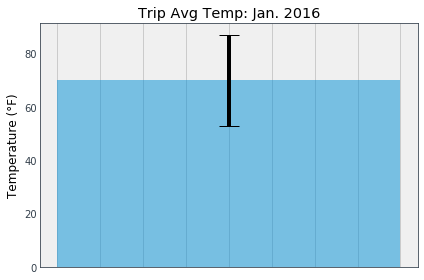

In [110]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_axis = jan_2016_temp_calcs
min_temp =  round(twenty_sixteen_temp_calcs[0][0],0)
max_temp = round(twenty_sixteen_temp_calcs[0][2],0)
x_pos = len(np.arange(min_temp, max_temp))
peak_to_peak =  (max_temp - min_temp)

# Build the plot
fig, ax = plt.subplots(ncols = 1)
ax.bar(x_pos, x_axis, yerr=peak_to_peak, align='center', alpha=0.5, ecolor='black', capsize = 10)
ax.set_ylabel('Temperature (°F)')
ax.set_title('Trip Avg Temp: Jan. 2016')
ax.yaxis.grid(False)
#plt.xticks(range(min(peak_to_peak), max(peak_to_peak)))

#remmove xticks
ax.set_xticklabels([])

# Save the figure and show
plt.tight_layout()
plt.savefig('adv_sql_trip_avg_temp.png')
plt.show()

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
